## Setup






In [0]:
import time
import os
import numpy as np
from google.colab import drive
import zipfile
import random
import json
from collections import defaultdict
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# If use google drive, we will mount Google Drive, so that you can restore your checkpoint 
# and continue trainig even if your previous Colab session dies.
# If set to True, follow on-screen instructions to access Google Drive (you must have a Google account).
# Code inspired by Coursera hse-aml

def mount_google_drive():
    mount_directory = "/content/gdrive"
    drive.mount(mount_directory, force_remount=True)
    drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0]
    return drive_root

ROOT_DIR =  mount_google_drive()
CHECKPOINT_ROOT = ROOT_DIR+ "/captioning/checkpoints/"
DATASET_DIR = ROOT_DIR + "/Dataset/"


def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(4))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/captioning/checkpoints/weights_4


## Download and Sample

In [3]:
def download_whole_set():
  tic = time.time()
  os.system("wget http://msvocds.blob.core.windows.net/coco2014/train2014.zip")
  os.system("wget http://msvocds.blob.core.windows.net/coco2014/val2014.zip")
  os.system("wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip")
  toc = time.time()
  
  print("The time for downloading the full train, val dataset is", str(toc - tic), "seconds")

download_whole_set()

The time for downloading the full train, val dataset is 1909.1370465755463 seconds


### We need to speficy what fraction of the whole data is needed

In [0]:
def sample_zip(fn_in, fn_out, fraction=0.46, seed=46):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        total_num = len(fin.filelist)
        sampled = random.sample(fin.filelist, int(total_num*fraction))
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
    print("The number of sampled examples is", str(int(total_num*fraction)))


In [40]:
sample_zip("train2014.zip", DATASET_DIR + "train2014_sample.zip")
sample_zip("val2014.zip", DATASET_DIR + "val2014_sample.zip")

The number of sampled examples is 38080
The number of sampled examples is 18632


## Extract the captions

In [0]:
def get_captions_for_fns(data_fn, zip_fn, zip_json_path):
    with zipfile.ZipFile(data_fn) as fin:
      fns = fin.namelist()
    
    fns = list(map(lambda x: x.split("/")[-1], fns))
      
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))

In [34]:
train_captions = get_captions_for_fns(DATASET_DIR + "train2014_sample.zip", "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(DATASET_DIR + "val2014_sample.zip", "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_captions))
print(len(val_captions))

16556
8101


## Visulize the images


In [0]:
def image_center_crop(img):
    h, w = img.shape[0], img.shape[1]
    pad_left = 0
    pad_right = 0
    pad_top = 0
    pad_bottom = 0
    if h > w:
        diff = h - w
        pad_top = diff - diff // 2
        pad_bottom = diff // 2
    else:
        diff = w - h
        pad_left = diff - diff // 2
        pad_right = diff // 2
    return img[pad_top:h-pad_bottom, pad_left:w-pad_right, :]


def decode_image_from_buf(buf):
    img = cv2.imdecode(np.asarray(bytearray(buf), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

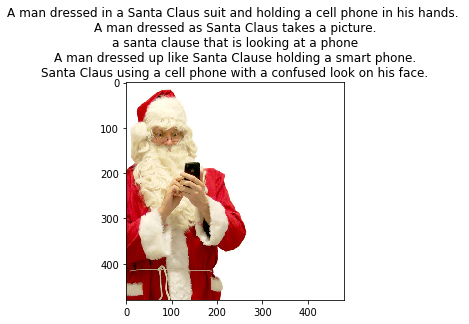

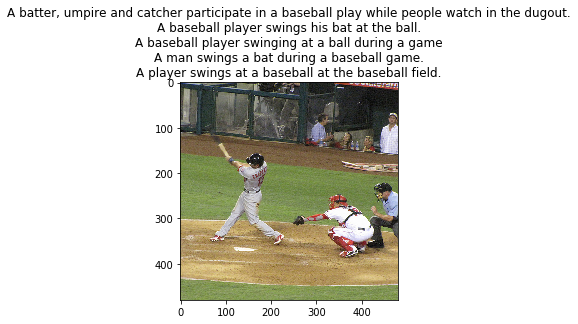

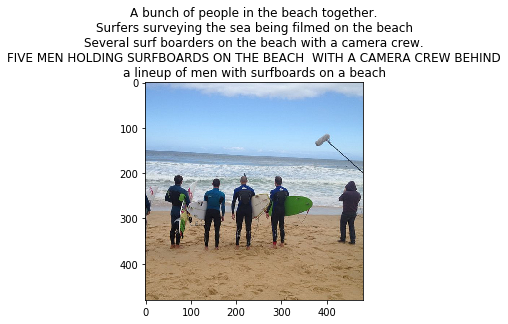

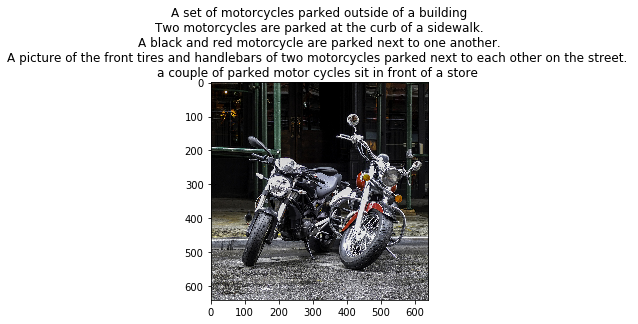

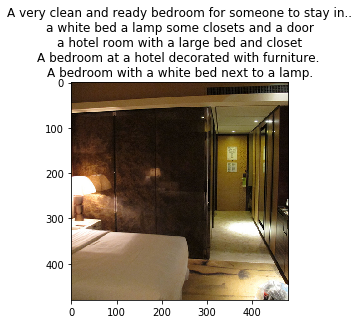

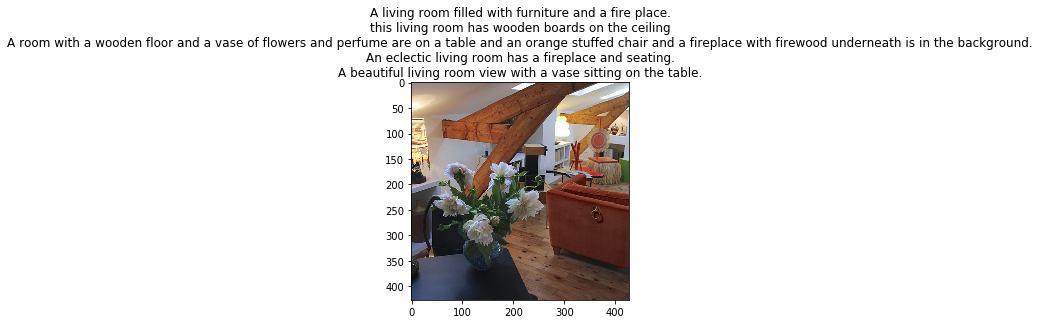

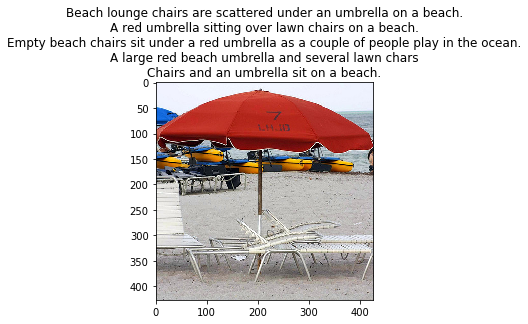

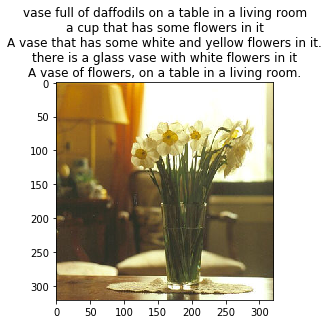

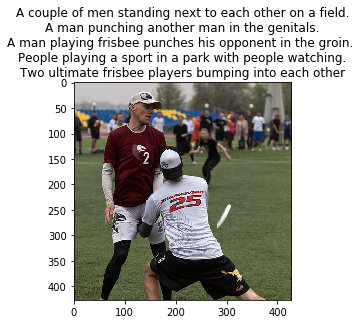

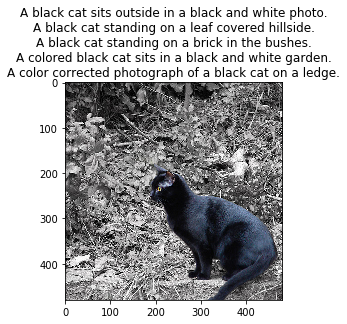

In [38]:
def show_trainig_example(train_data_fn, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    with zipfile.ZipFile(train_data_fn) as fin:
      train_img_fns = fin.namelist()
    
    train_img_fns = list(map(lambda x: x.split("/")[-1], train_img_fns))
    
    zf = zipfile.ZipFile(train_data_fn)
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = decode_image_from_buf(zf.read(example))
    plt.imshow(image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()

for i in np.random.randint(0, 10000, 10):
  show_trainig_example(DATASET_DIR + "train2014_sample.zip", train_captions, example_idx=i)